In [48]:
# Modeling
import tensorflow as tf
import tensorboard
from tensorflow.keras import layers, Sequential

# Cleaning / regex / preprocessing
import string
import re
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

df = pd.read_csv('../data/Emotion_final.csv')
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear


In [49]:
le = LabelEncoder()


df['target'] = le.fit_transform(df['Emotion'])
df

,Text,Emotion,target
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0
...,...,...,...
21454,Melissa stared at her friend in dism,fear,1
21455,Successive state elections have seen the gover...,fear,1
21456,Vincent was irritated but not dismay,fear,1
21457,Kendall-Hume turned back to face the dismayed ...,fear,1


In [50]:
df[df['target'] == 4]

,Text,Emotion,target
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
5,ive been feeling a little burdened lately wasn...,sadness,4
10,i feel like i have to make the suffering i m s...,sadness,4
13,i feel low energy i m just thirsty,sadness,4
...,...,...,...
20731,"The tears came , and rapidly dissolved her ang...",sadness,4
20732,Through a swell of tears Ruth stared incredulo...,sadness,4
20733,She glanced down at the linoleum in despai,sadness,4
20734,Perhaps it was despair that made me believe th...,sadness,4


In [51]:
df.isnull().sum()

Text       0
Emotion    0
target     0
dtype: int64

In [52]:
df[df['Text'] == '']

,Text,Emotion,target


<AxesSubplot:xlabel='target', ylabel='Count'>

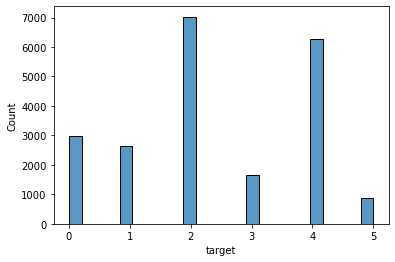

In [53]:
sns.histplot(df['target'])

In [54]:
url_re = re.compile(r'^https?://', re.IGNORECASE)

print(df.shape)

def is_url(word):
    return url_re.search(word) is not None


def keep_row(row):
    return not is_url(row['Text'])


df = df[df.apply(keep_row, axis=1)]

print(df.shape)

# No urls

(21459, 3)
(21459, 3)


### 2nd Dataset

In [55]:
twitter_df = pd.read_csv('../data/text_emotion.csv')

In [56]:
twitter_df = twitter_df.drop(['tweet_id', 'author'], axis=1)

In [57]:
df = df.rename(columns={"Emotion": "feelings", "Text": "content"})
twitter_df = twitter_df.rename(columns={"sentiment": "feelings"})

In [58]:
df.feelings.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [59]:
df.loc[df['feelings'] == 'love', 'feelings'] = 'happy'
df.loc[df['feelings'] == 'surprise', 'feelings'] = 'fear'

In [60]:
df['target'] = le.fit_transform(df['feelings'])
print(df.target.unique())
df

[3 0 2 1]


,content,feelings,target
0,i didnt feel humiliated,sadness,3
1,i can go from feeling so hopeless to so damned...,sadness,3
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,happy,2
4,i am feeling grouchy,anger,0
...,...,...,...
21454,Melissa stared at her friend in dism,fear,1
21455,Successive state elections have seen the gover...,fear,1
21456,Vincent was irritated but not dismay,fear,1
21457,Kendall-Hume turned back to face the dismayed ...,fear,1


In [63]:
df[df['target']==0]

,content,feelings,target
2,im grabbing a minute to post i feel greedy wrong,anger,0
4,i am feeling grouchy,anger,0
12,i think it s the easiest time of year to feel ...,anger,0
20,i feel irritated and rejected without anyone d...,anger,0
24,i already feel like i fucked up though because...,anger,0
...,...,...,...
21175,Irina hung up in exasperat,anger,0
21176,"She was acting like some idiotic schoolgirl , ...",anger,0
21177,Jean-Paul gave a sigh of exasperat,anger,0
21178,Parkin sighed with exasperat,anger,0


In [64]:
df[df['target']==1]

,content,feelings,target
6,ive been taking or milligrams or times recomme...,fear,1
7,i feel as confused about life as a teenager or...,fear,1
19,i now feel compromised and skeptical of the va...,fear,1
21,i am feeling completely overwhelmed i have two...,fear,1
31,i remember feeling acutely distressed for a fe...,fear,1
...,...,...,...
21454,Melissa stared at her friend in dism,fear,1
21455,Successive state elections have seen the gover...,fear,1
21456,Vincent was irritated but not dismay,fear,1
21457,Kendall-Hume turned back to face the dismayed ...,fear,1


In [65]:
df[df['target']==2]


,content,feelings,target
3,i am ever feeling nostalgic about the fireplac...,happy,2
8,i have been with petronas for years i feel tha...,happy,2
9,i feel romantic too,happy,2
11,i do feel that running is a divine experience ...,happy,2
14,i have immense sympathy with the general point...,happy,2
...,...,...,...
20263,"He uttered a short sharp bark , which made Ros...",happy,2
20264,"He considered this thoughtfully , then a gleam...",happy,2
20265,A look of intense amusement crossed Catherine ...,happy,2
20266,As a toddler she filled in concentric circles ...,happy,2


In [61]:
from sklearn.model_selection import train_test_split

X = df['content']
y = df.target

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42) 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42)
 
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(15450,)
(4292,)
(1717,)


In [17]:
twitter_df.feelings.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [18]:
twitter_df.loc[twitter_df['feelings'] == 'love', 'feelings'] = 'happy'
twitter_df.loc[twitter_df['feelings'] == 'surprise', 'feelings'] = 'fear'
twitter_df.loc[twitter_df['feelings'] == 'empty', 'feelings'] = 'sadness'
twitter_df.loc[twitter_df['feelings'] == 'enthusiasm', 'feelings'] = 'happy'
twitter_df.loc[twitter_df['feelings'] == 'surprise', 'feelings'] = 'fear'
twitter_df.loc[twitter_df['feelings'] == 'worry', 'feelings'] = 'fear'
twitter_df.loc[twitter_df['feelings'] == 'fun', 'feelings'] = 'happy'
twitter_df.loc[twitter_df['feelings'] == 'relief', 'feelings'] = 'anger'
twitter_df.loc[twitter_df['feelings'] == 'boredom', 'feelings'] = 'sadness'
twitter_df.loc[twitter_df['feelings'] == 'happiness', 'feelings'] = 'happy'
twitter_df.loc[twitter_df['feelings'] == 'hate', 'feelings'] = 'anger'

In [19]:
twitter_df['target'] = le.fit_transform(twitter_df['feelings'])
print(twitter_df.feelings.unique())
print(twitter_df.target.unique())
twitter_df

['sadness' 'happy' 'neutral' 'fear' 'anger']
[4 2 3 1 0]


,feelings,content,target
0,sadness,@tiffanylue i know i was listenin to bad habi...,4
1,sadness,Layin n bed with a headache ughhhh...waitin o...,4
2,sadness,Funeral ceremony...gloomy friday...,4
3,happy,wants to hang out with friends SOON!,2
4,neutral,@dannycastillo We want to trade with someone w...,3
...,...,...,...
39995,neutral,@JohnLloydTaylor,3
39996,happy,Happy Mothers Day All my love,2
39997,happy,Happy Mother's Day to all the mommies out ther...,2
39998,happy,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,2


array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

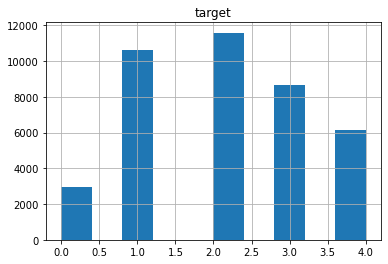

In [20]:
twitter_df.hist()

### Twitter_df cleaning

In [21]:
twitter_df

,feelings,content,target
0,sadness,@tiffanylue i know i was listenin to bad habi...,4
1,sadness,Layin n bed with a headache ughhhh...waitin o...,4
2,sadness,Funeral ceremony...gloomy friday...,4
3,happy,wants to hang out with friends SOON!,2
4,neutral,@dannycastillo We want to trade with someone w...,3
...,...,...,...
39995,neutral,@JohnLloydTaylor,3
39996,happy,Happy Mothers Day All my love,2
39997,happy,Happy Mother's Day to all the mommies out ther...,2
39998,happy,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,2


In [22]:
twitter_df['content'] = twitter_df['content'].str.replace(r'\s*@\w+', '', regex=True)
twitter_df['content'] = twitter_df['content'].str.replace(r'\s*\B@\w+', '', regex=True)
twitter_df['content'] = twitter_df['content'].str.replace(r'\s*@\S+', '', regex=True)
twitter_df['content'] = twitter_df['content'].str.replace(r'\s*@\S+\b', '', regex=True)

In [23]:
twitter_df[twitter_df['content'] == '']
twitter_df.drop(twitter_df[twitter_df.content == ''].index, inplace=True)

In [24]:
twitter_df[twitter_df.index == 39998].content

39998     WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEEP OUT MY ...
Name: content, dtype: object

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

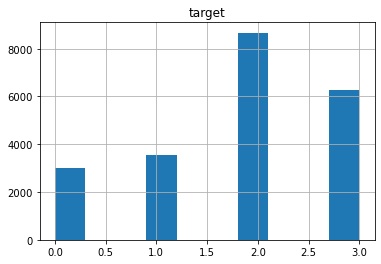

In [25]:
df.hist()

In [26]:
# for hugging face

kaggle_train, kaggle_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
twitter_train, twitter_test = train_test_split(twitter_df, test_size=0.2, shuffle=True, random_state=42)

kaggle_train.to_csv('../data/kaggle_train.csv', index=False)
kaggle_test.to_csv('../data/kaggle_test.csv', index=False)
twitter_train.to_csv('../data/twitter_train.csv', index=False)
twitter_test.to_csv('../data/twitter_test.csv', index=False)

In [27]:
merged_df = pd.merge(left=twitter_df, right=df, how='outer')
merged_df

,feelings,content,target
0,sadness,i know i was listenin to bad habit earlier a...,4
1,sadness,Layin n bed with a headache ughhhh...waitin o...,4
2,sadness,Funeral ceremony...gloomy friday...,4
3,happy,wants to hang out with friends SOON!,2
4,neutral,We want to trade with someone who has Houston...,3
...,...,...,...
61378,fear,Melissa stared at her friend in dism,1
61379,fear,Successive state elections have seen the gover...,1
61380,fear,Vincent was irritated but not dismay,1
61381,fear,Kendall-Hume turned back to face the dismayed ...,1


In [28]:
merged_df.feelings.unique()

array(['sadness', 'happy', 'neutral', 'fear', 'anger'], dtype=object)

In [29]:
merged_df.drop(merged_df[merged_df.feelings == 'neutral'].index, inplace=True) # Test
merged_df['target'] = le.fit_transform(merged_df['feelings'])

(52801, 3)


array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

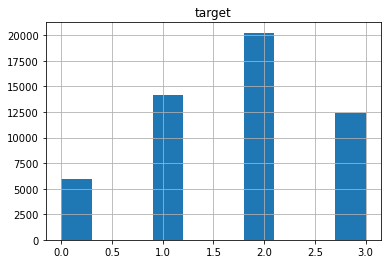

In [30]:
print(merged_df.shape)
merged_df.hist()

In [31]:
from sklearn.model_selection import train_test_split

X_aug = merged_df['content']
y_aug = merged_df.target

X_train_aug, X_valid_aug, y_train_aug, y_valid_aug = train_test_split(X_aug, y_aug, test_size=0.2, shuffle=True, random_state=42) 
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_train_aug, y_train_aug, test_size=0.1, shuffle=True, random_state=42) 

In [32]:
X.to_csv('../data/X.csv', index = False)
y.to_csv('../data/y.csv', index = False)
X_aug.to_csv('../data/X_aug.csv', index = False)
y_aug.to_csv('../data/y_aug.csv', index = False)

In [33]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
    
# Model constants.
max_features = 20000
embedding_dim = 256
sequence_length = 100

In [34]:
from tensorflow.keras import layers

vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    max_tokens=max_features,
    output_sequence_length=sequence_length,
)

# Let's call `adapt`:
vectorize_layer.adapt(X_train)

In [42]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(42)

# A integer input for vocab indices.
input = tf.keras.Input(shape=(1,), dtype='string')
x = vectorize_layer(input)

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(input_dim = max_features, output_dim = embedding_dim, embeddings_initializer='uniform')(x)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling.
x = layers.Conv1D(128, 7, padding="same", activation="relu", strides=3)(x)
x = layers.Dropout(0.4)(x)
x = layers.Conv1D(128, 7, padding="same", activation="relu", strides=3)(x)
x = layers.Dropout(0.3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
output = layers.Dense(4, activation="softmax", name="predictions")(x)

model = tf.keras.Model(input, output)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [43]:
epochs = 4
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs)

Epoch 1/4
483/483 [==============================] - 40s 81ms/step - loss: 1.0757 - acc: 0.5287 - val_loss: 0.7886 - val_acc: 0.6556
Epoch 2/4
483/483 [==============================] - 39s 81ms/step - loss: 0.5807 - acc: 0.7542 - val_loss: 0.4544 - val_acc: 0.8222
Epoch 3/4
483/483 [==============================] - 39s 81ms/step - loss: 0.3426 - acc: 0.8669 - val_loss: 0.3212 - val_acc: 0.8959
Epoch 4/4
483/483 [==============================] - 40s 84ms/step - loss: 0.1745 - acc: 0.9452 - val_loss: 0.2541 - val_acc: 0.9231


In [44]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
14/14 [==============================] - 1s 20ms/step - loss: 0.2370 - acc: 0.9208
test loss, test acc: [0.2370186746120453, 0.9207921028137207]


In [45]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

27/27 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       221
           1       0.93      0.87      0.90       283
           2       0.97      0.95      0.96       717
           3       0.91      0.95      0.93       496

    accuracy                           0.92      1717
   macro avg       0.90      0.90      0.90      1717
weighted avg       0.92      0.92      0.92      1717



In [39]:
# tf.keras.backend.clear_session()

# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

# epochs = 2
# history = model.fit(X_train_aug, y_train_aug, validation_data=(X_valid_aug, y_valid_aug), epochs=epochs)

In [47]:
tf.keras.models.save_model(model=model, filepath='./../FastAPI_Backend/Conv1d', save_format='tf')

INFO:tensorflow:Assets written to: ./../FastAPI_Backend/Conv1d\assets


In [46]:
# tf.keras.models.save_model(model=model, filepath='./../FastAPI_Backend/Conv1d.h5')

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x0000021334F888E0>]